# Linear Regression

In this notebook, we will look at the simplest regression model, the linear regression which can be described as $\hat{y} = \sum_i a_i \cdot x_i$.

For this demo, we will generate some simple artificial dataset and then explore various simple regression methods, such as the "plain" simple linear regression, regularised linear regression, and how to handle polynomials fits.



In [54]:
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, HuberRegressor
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Generate artificial data

Define a small function which generates test data according to a linear model in the following way:
   * x-axis: Random numbers drawn from a Gaussian (Normal) distribution with default parameters (mean=0, sigma = 1)
   * y-axis: x-value times slope plus a noise term (Gaussian random numbers)
   
The input parameters to this function are:
   * The number of samples to generate
   * slope
   * noise

The output of the function is:
  * array of x values
  * array of y values

In [15]:
def generate_test_data(slope, noise, n_samples):
    x = norm.rvs(size=n_samples)
    y = slope * x + norm.rvs(scale=noise, size=n_samples)
    return x,y

In [16]:
true_slope = 1.0
noise_level = 1
n_samples = 100

x, y = generate_test_data(true_slope, noise_level, n_samples)

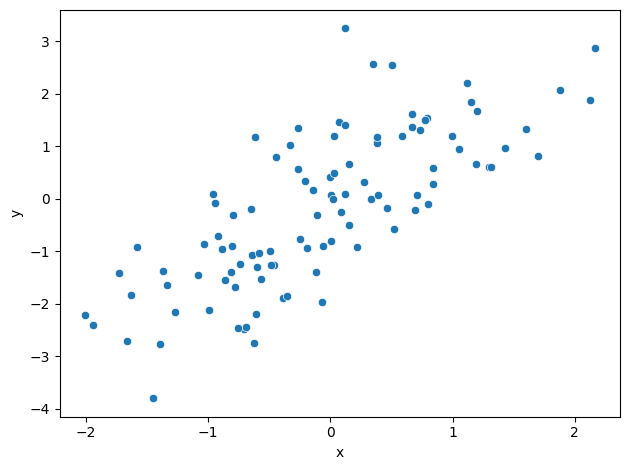

In [19]:
sns.scatterplot(x=x, y=y)
plt.xlabel('x', size=15)
plt.ylabel('y', size=15)
plt.tight_layout()
plt.show()

# Ordinary Linear Regression (OLS)

We first look at the simplest case for the linear regression, fitting a straight line to the data.

[array([[1.21497597]]), 0.0]


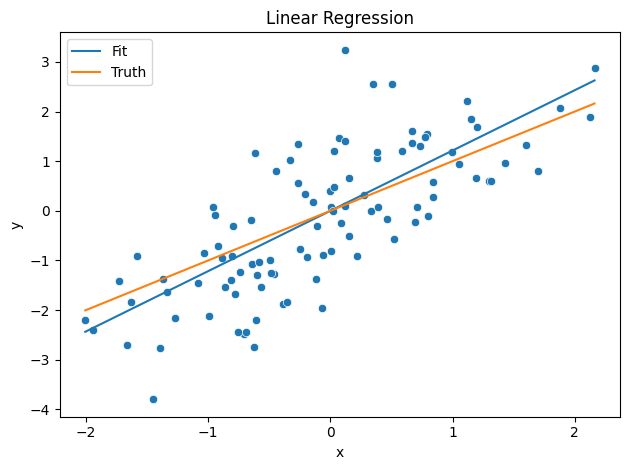

In [21]:
lm = LinearRegression(fit_intercept=False)
lm.fit(x.reshape(-1, 1),y.reshape(-1, 1))
print([lm.coef_, lm.intercept_])

x_space = np.linspace(np.min(x), np.max(x))
sns.scatterplot(x=x, y=y)
plt.plot(x_space, lm.predict(x_space[:, np.newaxis]), label='Fit')
plt.plot(x_space, true_slope*x_space, label='Truth')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression')
plt.tight_layout()
plt.legend()
plt.show()

# Polynomial Fit

The above simple linear regression worked quite well, given the sparsity of the data.

Let's now try some data with a more complicated shape and generate data from a polynomial function. The NumPy library provides a number of [convenience functions for polynomial](https://numpy.org/doc/stable/reference/routines.polynomials.html). In particular, we can specify a list of coefficients and then use ```np.polynomial.polynomial.Polynomia``` to "convert" this into a corresponding polynomial function.

In [30]:
def generate_data_from_func(func, noise, n_samples):
    x = 5*np.random.rand(n_samples) - 2.5
    y = func(x) + norm.rvs(scale=noise, size=n_samples)
    #return np.transpose([x]), y
    return x,y

In [31]:
true_coefficients = [0, 1, 8, -8]
true_degree = len(true_coefficients) - 1
print('True degree of polynomial: {}'.format(true_degree))

true_poly = np.polynomial.polynomial.Polynomial(true_coefficients)
x, y = generate_data_from_func(true_poly, 5, 25)

True degree of polynomial: 3


In [32]:
print(x)

[ 0.2513288  -0.92424404  1.50522857  2.00048027 -1.56661735  2.32554123
 -0.26011933  0.60682477  0.9031809  -1.64544008 -2.44007169 -1.75932259
 -1.71453087  0.5592937  -2.37104837 -0.36964595 -1.22398804  1.88411752
 -2.40492839  1.82486903 -0.3881358   1.32519684 -1.66128279  0.24652489
  0.80629894]


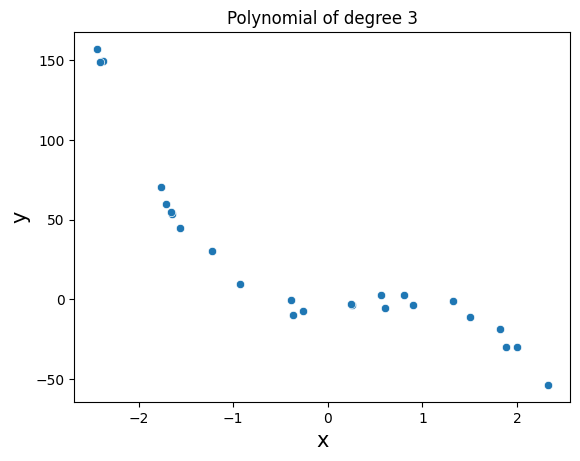

In [33]:
sns.scatterplot(x=x, y=y)
plt.xlabel('x', size=15)
plt.ylabel('y', size=15)
plt.title('Polynomial of degree {}'.format(true_degree))

plt.show()

Now we fit the polynomial. Before we can use the linear regression above, we need to create the relevant features for the polynomial, corresponding to the respective power of the polynomial, but also their (potential) interaction. This means for two variables $x_1, x_2$, we need to look at the following higher order terms: $x_1^2, x_1 \cdot x_2, x_2^2$.

More information can be found in the [documentation](https://scikit-learn.org/stable/modules/preprocessing.html#polynomial-features) and the [class description](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) of the sklearn package.

In [50]:
# create polynomial features: define method

degree = true_degree + 10 #this is a parameter you need to set (hyperparameter)
polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)

# now take the input features (x) and "transform" then according to the above specification
x_poly = polynomial_features.fit_transform(x.reshape(-1, 1))

In [51]:
# now we can do the linear regression again:

lm = LinearRegression(fit_intercept=True)
lm.fit(x_poly, y)
print(lm.coef_)

[ 0.00000000e+00  3.77599406e+00 -1.17106404e+01  1.34687995e+01
  5.01438825e+01 -6.02634021e+01 -3.70942434e+01  5.05172394e+01
  1.13420607e+01 -1.83594716e+01 -1.43165319e+00  3.00477707e+00
  5.75438986e-02 -1.81672078e-01]


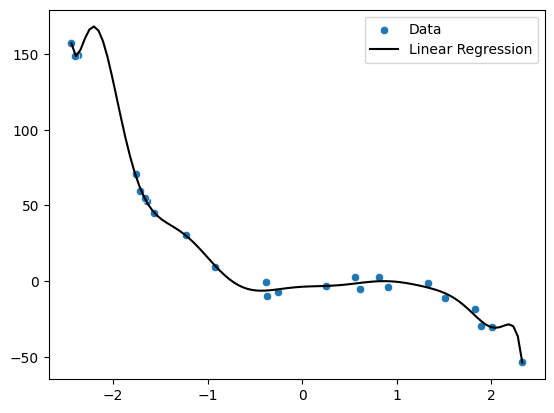

In [53]:
x_space = np.linspace(np.min(x), np.max(x), 101)
x_space_poly =  polynomial_features.fit_transform(x_space[:, np.newaxis])
sns.scatterplot(x=x,y=y,label='Data')

plt.plot(x_space, lm.predict(x_space_poly), label='Linear Regression', color='black')

plt.legend()
plt.show()

We can see that this fit does not describe the data too well, in particular, it's too "wiggly". We can therefore assume that the model is prone to overfitting.
We can now follow two avenues: Either adjust the degree of the polynomial used in the fit to the data and/or apply some regularisation.

Here, we will use [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) and [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) approaches, making use of the cross-validation feature to give us the best set of parameters when exploring a wide range of regularisation parameters

In [61]:
ridge_regressor = RidgeCV(fit_intercept=True,alphas=[0.1, 0.5,1,2,5,10,15,20,100])
ridge_regressor.fit(x_poly, y)
print(ridge_regressor.coef_)

[ 0.         -0.2968025   0.32205431 -0.43769424  0.44309384 -0.5667587
  0.49217658 -0.62464414  0.34366079 -0.41388409 -0.10927938  0.18683133
  0.00659839 -0.01739491]


In [62]:
lasso_regressor = LassoCV(fit_intercept=True, max_iter = 100000000, eps=0.01, alphas=[0.1, 0.5,1,2,5,10,15,20,100])
lasso_regressor.fit(x_poly, y)
print(lasso_regressor.coef_)

[ 0.         -0.          0.         -0.          0.         -0.74469888
  1.24288479 -1.25077109  0.         -0.         -0.04913807  0.10036106
  0.00305207 -0.01149239]


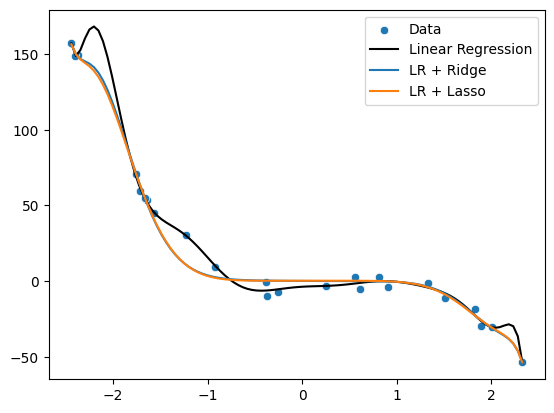

In [63]:
x_space = np.linspace(np.min(x), np.max(x), 101)
x_space_poly =  polynomial_features.fit_transform(x_space[:, np.newaxis])
sns.scatterplot(x=x,y=y,label='Data')

plt.plot(x_space, lm.predict(x_space_poly), label='Linear Regression', color='black')
plt.plot(x_space, ridge_regressor.predict(x_space_poly), label='LR + Ridge')
plt.plot(x_space, lasso_regressor.predict(x_space_poly), label='LR + Lasso')
plt.legend()
plt.show()

We can see that the regularised fit is much smoother and closer to what we would expect from the process underlying the data.
In this case, Lasso and Ridge regressions have resulted in very similar fits, but this does not always have to be the case.

# Linear Regression with Outliers

In the next step, we want to investigate how regularisation can help us in data with outliers.
Outliers are a common issue when dealing with "real-world" data. They arise from two sources: Either there is something wrong with the way we acquire the data. For example, an instrument may have a glitch, is miscalibrated or faulty. If data have to be entered manually, we may, for example, make a mistake in this process. ON the other hand, an outlier may represent a rare but genuine event. For example, in regions with moderate weather, we may typically experience low to moderate wind speeds. However, in rare events, a hurricane may occur. In this case, the outline is a genuine data point, albeit not being described by the bulk of the data.

Dealing with outliers requires great care and we need to investigate the source of the outlier. If the outlier is due to an error in the way the data are acquired, we can, for example, remove these data points from our dataset, *provided* we have fixed the source of the errors. If the outliers are due to genuine events, we need to treat them differently and discuss for the concrete case which steps are most appropriate.

In our exercise here, we want to investigate how the regularisation methods we have encountered so far deal with outliers.

In a first step, we generate data similar to what we did in the beginning and then add one (but extreme) outlier.

In [64]:
def generate_test_data(slope, noise, n_samples):
    x = norm.rvs(size=n_samples)
    y = slope * x + norm.rvs(scale=noise, size=n_samples)
    return x,y

In [65]:
true_slope = 1.0
noise_level = 1
n_samples = 100

x, y = generate_test_data(true_slope, noise_level, n_samples)

In [66]:
# add one outlier 
x_1=np.append(x,[2.0])
y_1=np.append(y,[-50.0])

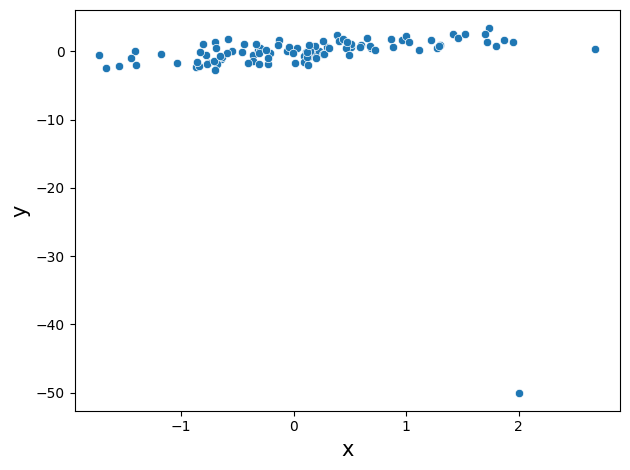

In [68]:
sns.scatterplot(x=x_1, y=y_1)
plt.xlabel('x', size=15)
plt.ylabel('y', size=15)
plt.tight_layout()
plt.show()

In a first step, we try the standard linear regression - but do not expect this to do well.

[array([[-0.26607019]]), 0.0]


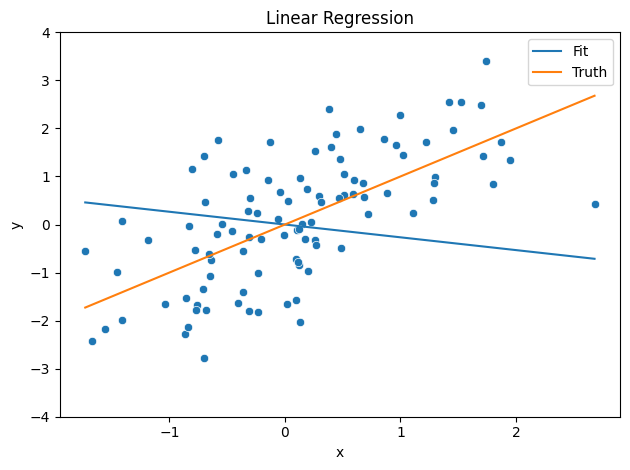

In [70]:
lm = LinearRegression(fit_intercept=False)
lm.fit(x_1.reshape(-1, 1),y_1.reshape(-1, 1))
print([lm.coef_, lm.intercept_])

x_space = np.linspace(np.min(x_1), np.max(x_1))
sns.scatterplot(x=x_1, y=y_1)
plt.plot(x_space, lm.predict(x_space[:, np.newaxis]), label='Fit')
plt.plot(x_space, true_slope*x_space, label='Truth')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-4.0,4)
plt.title('Linear Regression')
plt.tight_layout()
plt.legend()
plt.show()

We now try both Lasso and Ridge regression
(here we do not use the cross-validation approach but set the regularisation parameter manually. You can explore this setting)

Lasso coefficient [-0.02131139]
Ridge coefficient [[-0.26542696]]


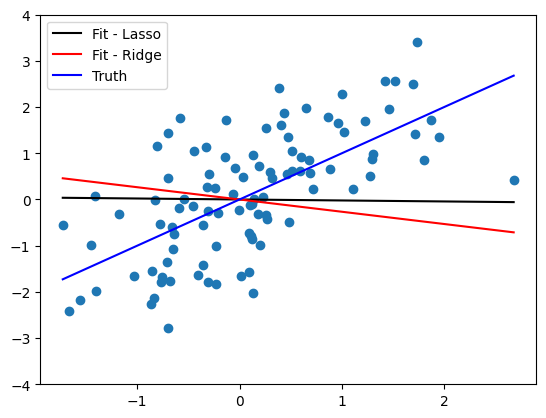

In [83]:
alpha = 0.2

lasso = Lasso(fit_intercept=False, alpha = alpha)
lasso.fit(x_1.reshape(-1,1), y_1.reshape(-1,1))
print('Lasso coefficient {}'.format(lasso.coef_)    )

ridge = Ridge(fit_intercept=False, alpha = alpha)
ridge.fit(x_1.reshape(-1,1),y_1.reshape(-1,1))
print('Ridge coefficient {}'.format(ridge.coef_)   )

plt.scatter(x_1,y_1)
x_space = np.linspace(np.min(x_1), np.max(x_1))
plt.plot(x_space, lasso.predict(x_space[:, np.newaxis]), label='Fit - Lasso', color='black')
plt.plot(x_space, ridge.predict(x_space[:, np.newaxis]), label='Fit - Ridge', color='red')
plt.plot(x_space, true_slope*x_space, label='Truth', color='blue')
plt.ylim(-4.0,4)
plt.legend()
plt.show()

We can see that neither of these methods perform well due to the outlier.

What is the underlying issue?
When we perform the linear regression, we minimise the following loss function: $\mathcal{L} = \sum_i (y_i - \hat{y_i})^2$, where $y_i$ are the data points and $\hat{y_i}$ are the corresponding values of our linear prediction model.
This works fairly well in the case of no outliers, and, as we have seen in the example of the polynomial fit, Lasso and Ridge regression can help us to avoid overfitting.
However, here we have one extreme outlier that dominates the loss function because its large deviation from the prediction.

It now depends on what we need to do (and this depends on the unique circumstances of each specific analysis). Ideally, we would remove the outlier from the data, either because they are errors in the data or we have a separate model for such rare events. 
However, this may not be practical in all circumstances. We can then use a different approach in the fit and replace the purely quadratic loss function above with, for example, the Huber loss. This is, essentially, a combination of the quadratic loss we have used so far (for the bulk of the data), together with a linear loss function for detected outliers. The linear part of the loss function places less weight on the outlier compared to the quadratic loss function. In scikit-learn, this is implemented as the [Huber Regressor](https://scikit-learn.org/stable/modules/linear_model.html#huber-regression)


Reference: Huber, P. J. (1964). Robust estimation of a location parameter: Annals Mathematics Statistics, 35. Ji, S., Xue, Y. and Carin, L.(2008),‘Bayesian compressive sensing’, IEEE Transactions on signal processing, 56(6), 2346-2356.

In [85]:
huber = HuberRegressor(alpha=alpha, epsilon=1.35)
huber.fit(x_1.reshape(-1,1), y_1)
print('Huber coefficient {}'.format(huber.coef_))  

Huber coefficient [1.00612488]


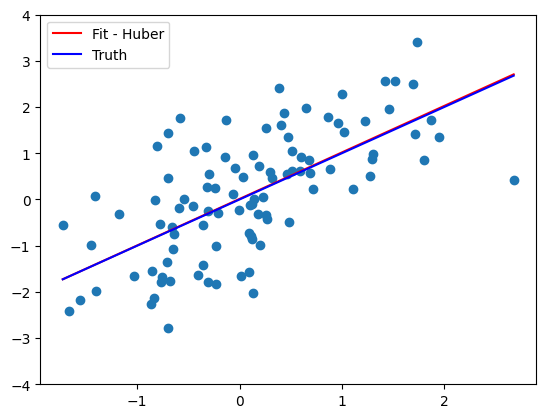

In [86]:
plt.scatter(x_1,y_1)
x_space = np.linspace(np.min(x_1), np.max(x_1))
plt.plot(x_space, huber.predict(x_space[:, np.newaxis]), label='Fit - Huber', color='red')
plt.plot(x_space, true_slope*x_space, label='Truth', color='blue')
plt.ylim(-4.0,4)
plt.legend()
plt.show()

As we can see, this works well in this specific case.
However, we do not treat the outlier well now:

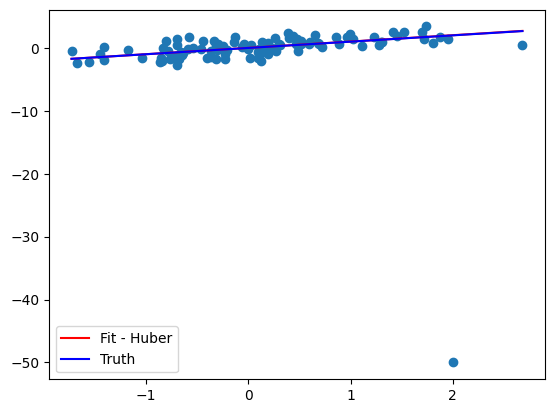

In [87]:
plt.scatter(x_1,y_1)
x_space = np.linspace(np.min(x_1), np.max(x_1))
plt.plot(x_space, huber.predict(x_space[:, np.newaxis]), label='Fit - Huber', color='red')
plt.plot(x_space, true_slope*x_space, label='Truth', color='blue')

plt.legend()
plt.show()

This is the same plot as above, with the only difference that we no longer force the range of the $y$ axis that is displayed in the plot.
We can see that the bulk of the data are described well - but the outlier remains an outlier in the model. Whether or not this a good approach needs to be discussed in the context of the specific application.